In [1]:

!pip install timm --quiet

import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00


In [2]:
!pip install opendatasets --quiet

In [3]:
import opendatasets as od

# Replace with your Kaggle API key path
od.download('https://www.kaggle.com/datasets/msambare/fer2013')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gunjankumarmishra
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


100%|██████████| 60.3M/60.3M [00:00<00:00, 1.35GB/s]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [30]:
from torch.utils.data import DataLoader, random_split

# Transform (convert grayscale to 3-channel for Swin)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224,0.225])
])

# Load datasets from folders
train_data = datasets.ImageFolder(root='/content/fer2013/train', transform=transform)
test_data = datasets.ImageFolder(root='/content/fer2013/test', transform=transform)

# Split training data: 90% train, 10% validation
train_len = int(0.9 * len(train_data))
val_len = len(train_data) - train_len
train_dataset, val_dataset = random_split(train_data, [train_len, val_len])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes  # Emotion labels


In [7]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [8]:
from torchvision.models import swin_t, Swin_T_Weights

class SwinWithSE(nn.Module):
    def __init__(self, num_classes):
        super(SwinWithSE, self).__init__()
        self.backbone = swin_t(weights=Swin_T_Weights.DEFAULT)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Identity()  # Remove original classification head

        self.se = SEBlock(in_features)
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.se(x.unsqueeze(-1).unsqueeze(-1)).squeeze(-1).squeeze(-1)
        x = self.classifier(x)
        return x


In [9]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [10]:
import time
model = SwinWithSE(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    # val_loss, val_acc = evaluate(model, val_loader, criterion)

    end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} - Time: {end_time-start_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 190MB/s] 


Epoch 1/10 - Time: 394.28s
Train Loss: 1.2337 | Acc: 0.5297
Epoch 2/10 - Time: 400.82s
Train Loss: 0.9654 | Acc: 0.6426
Epoch 3/10 - Time: 398.46s
Train Loss: 0.8350 | Acc: 0.6912
Epoch 4/10 - Time: 397.44s
Train Loss: 0.7249 | Acc: 0.7316
Epoch 5/10 - Time: 398.97s
Train Loss: 0.6209 | Acc: 0.7740
Epoch 6/10 - Time: 399.66s
Train Loss: 0.5121 | Acc: 0.8157
Epoch 7/10 - Time: 395.49s
Train Loss: 0.4357 | Acc: 0.8433
Epoch 8/10 - Time: 395.88s
Train Loss: 0.3489 | Acc: 0.8781
Epoch 9/10 - Time: 395.90s
Train Loss: 0.3055 | Acc: 0.8924
Epoch 10/10 - Time: 397.23s
Train Loss: 0.2511 | Acc: 0.9119


In [31]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")


Test Loss: 0.8908 | Accuracy: 0.7978


In [32]:
def evaluate_per_class(model, loader, class_names):
    model.eval()
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print("\nAccuracy per class:")
    for i in range(len(class_names)):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {class_names[i]} : {accuracy:.2f} %')
        else:
            print(f'No instances of {class_names[i]} in this dataset.')

evaluate_per_class(model, test_loader, class_names)


Accuracy per class:
Accuracy of angry : 82.45 %
Accuracy of disgust : 74.71 %
Accuracy of fear : 58.94 %
Accuracy of happy : 89.98 %
Accuracy of neutral : 84.77 %
Accuracy of sad : 59.20 %
Accuracy of surprise : 92.19 %


In [33]:
from sklearn.metrics import f1_score, classification_report
import torch

def f1_score_per_class(model, loader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate F1-score
    f1_scores = f1_score(all_labels, all_preds, average=None, labels=range(len(class_names)))

    print("\nF1 Score per class:")
    for i, class_name in enumerate(class_names):
        print(f'F1 Score of {class_name} : {f1_scores[i]:.4f}')


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


f1_score_per_class(model, test_loader, class_names, device)


F1 Score per class:
F1 Score of angry : 0.7490
F1 Score of disgust : 0.7738
F1 Score of fear : 0.6583
F1 Score of happy : 0.9227
F1 Score of neutral : 0.7690
F1 Score of sad : 0.6624
F1 Score of surprise : 0.8979

Classification Report:
              precision    recall  f1-score   support

       angry       0.69      0.82      0.75       809
     disgust       0.80      0.75      0.77        87
        fear       0.75      0.59      0.66       716
       happy       0.95      0.90      0.92      1606
     neutral       0.70      0.85      0.77      1064
         sad       0.75      0.59      0.66       875
    surprise       0.88      0.92      0.90       768

    accuracy                           0.80      5925
   macro avg       0.79      0.77      0.78      5925
weighted avg       0.80      0.80      0.80      5925



100%|██████████| 93/93 [00:37<00:00,  2.45it/s]


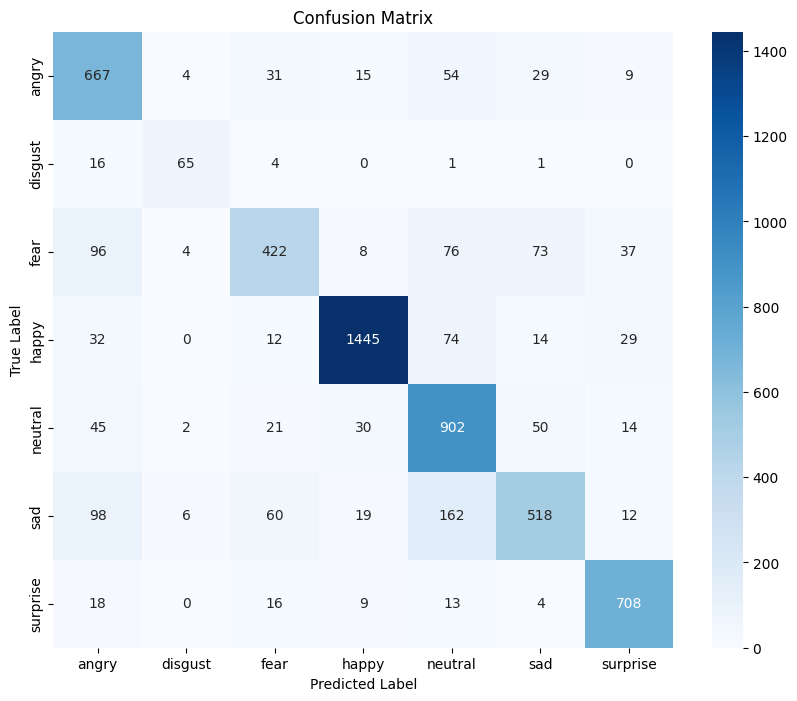

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get true labels and predictions for the test set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


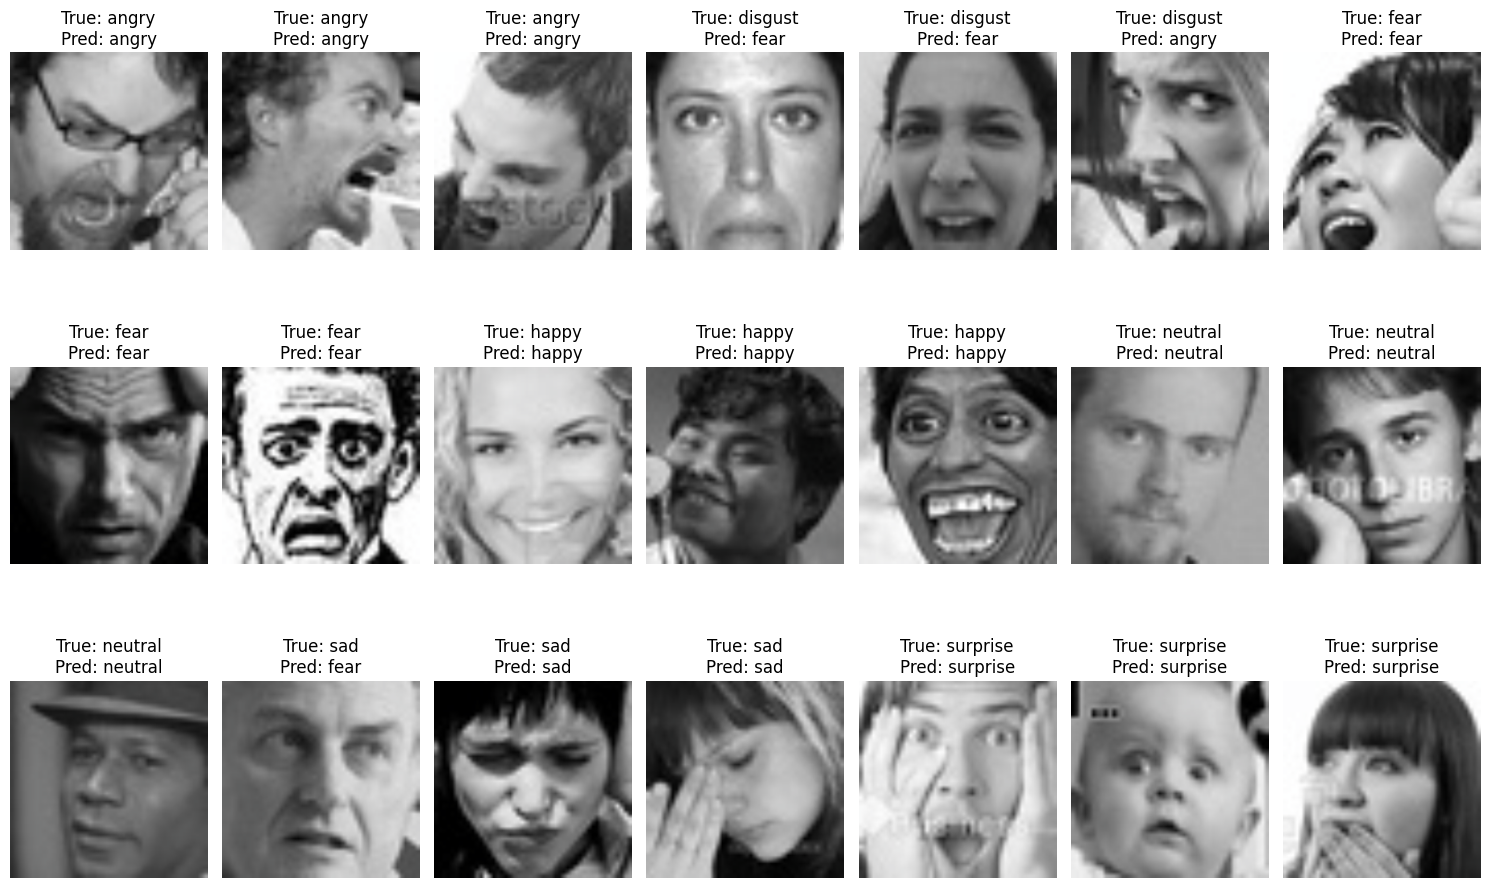

In [37]:
import matplotlib.pyplot as plt
import numpy as np
def show_prediction_samples(model, loader, class_names, device, num_samples_per_class=3):
    model.eval()
    samples_shown_per_class = {class_name: 0 for class_name in class_names}
    plt.figure(figsize=(15, 10))
    plot_index = 1

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                true_label_index = labels[i].item()
                predicted_label_index = predicted[i].item()
                true_label = class_names[true_label_index]
                predicted_label = class_names[predicted_label_index]

                if samples_shown_per_class[true_label] < num_samples_per_class:
                    # Denormalize the image for display
                    img = images[i].cpu().numpy().transpose((1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)

                    plt.subplot(num_samples_per_class, len(class_names), plot_index)
                    plt.imshow(img)
                    plt.title(f"True: {true_label}\nPred: {predicted_label}")
                    plt.axis('off')
                    plot_index += 1
                    samples_shown_per_class[true_label] += 1

            # Stop if we have enough samples for all classes
            if all(count >= num_samples_per_class for count in samples_shown_per_class.values()):
                break

    plt.tight_layout()
    plt.show()

# Call the function to display prediction samples
show_prediction_samples(model, test_loader, class_names, device)